## Breast Cancer Classification

This notebook works on the classification task.
We used the Breast Cancer dataset, which is different from the WDBC dataset used in the lab tutorials.
THe dataset consists of nine features, including:
1. Class: no-recurrence-events, recurrence-events 
</br>    -> 0, 1
2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99. 
</br>    -> 1, 2, 3, 4, 5, 6, 7, 8, 9
3. menopause: lt40, ge40, premeno. 
</br>    -> Since it has three different types. We divided it into three features: lt40(0, 1), ge40(0, 1), premeno(0, 1)
4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59. 
</br>    -> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39. 
</br>    -> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
6. node-caps: yes, no, ?. 
</br>    -> 1, 0, 2
7. deg-malig: 1, 2, 3.
8. breast: left, right.
</br>    -> 1, 0
9. breast-quad: left-up, left-low, right-up, right-low, central.
</br>    -> 1, 2, 3, 4, 5
10. irradiat: yes, no.
</br>    -> 1, 0
Link: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer

The dataset was then converted from .data file into .csv file to make data pre-processing task easier to carry out.
The dataset was first analysed in 
1. logistic regression
2. SVM
3. Decision tree
4. ANN

In [116]:
# import all the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import h5py

### 1. Data preprocessing

In [117]:
all_df = pd.read_csv('breast-cancer.csv', index_col=False)
all_df = shuffle(all_df)
X = all_df.drop('Irradiant', axis=1)
target = all_df['Irradiant']

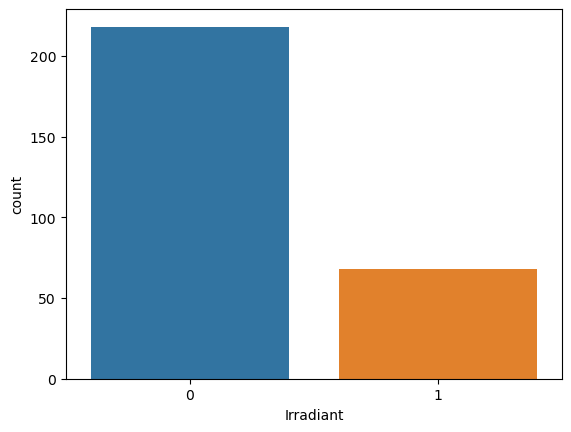

In [118]:
# Check the distributions of 0 and 1 as labelled in Column "Irradiant"
sns.countplot(x="Irradiant", data=all_df)

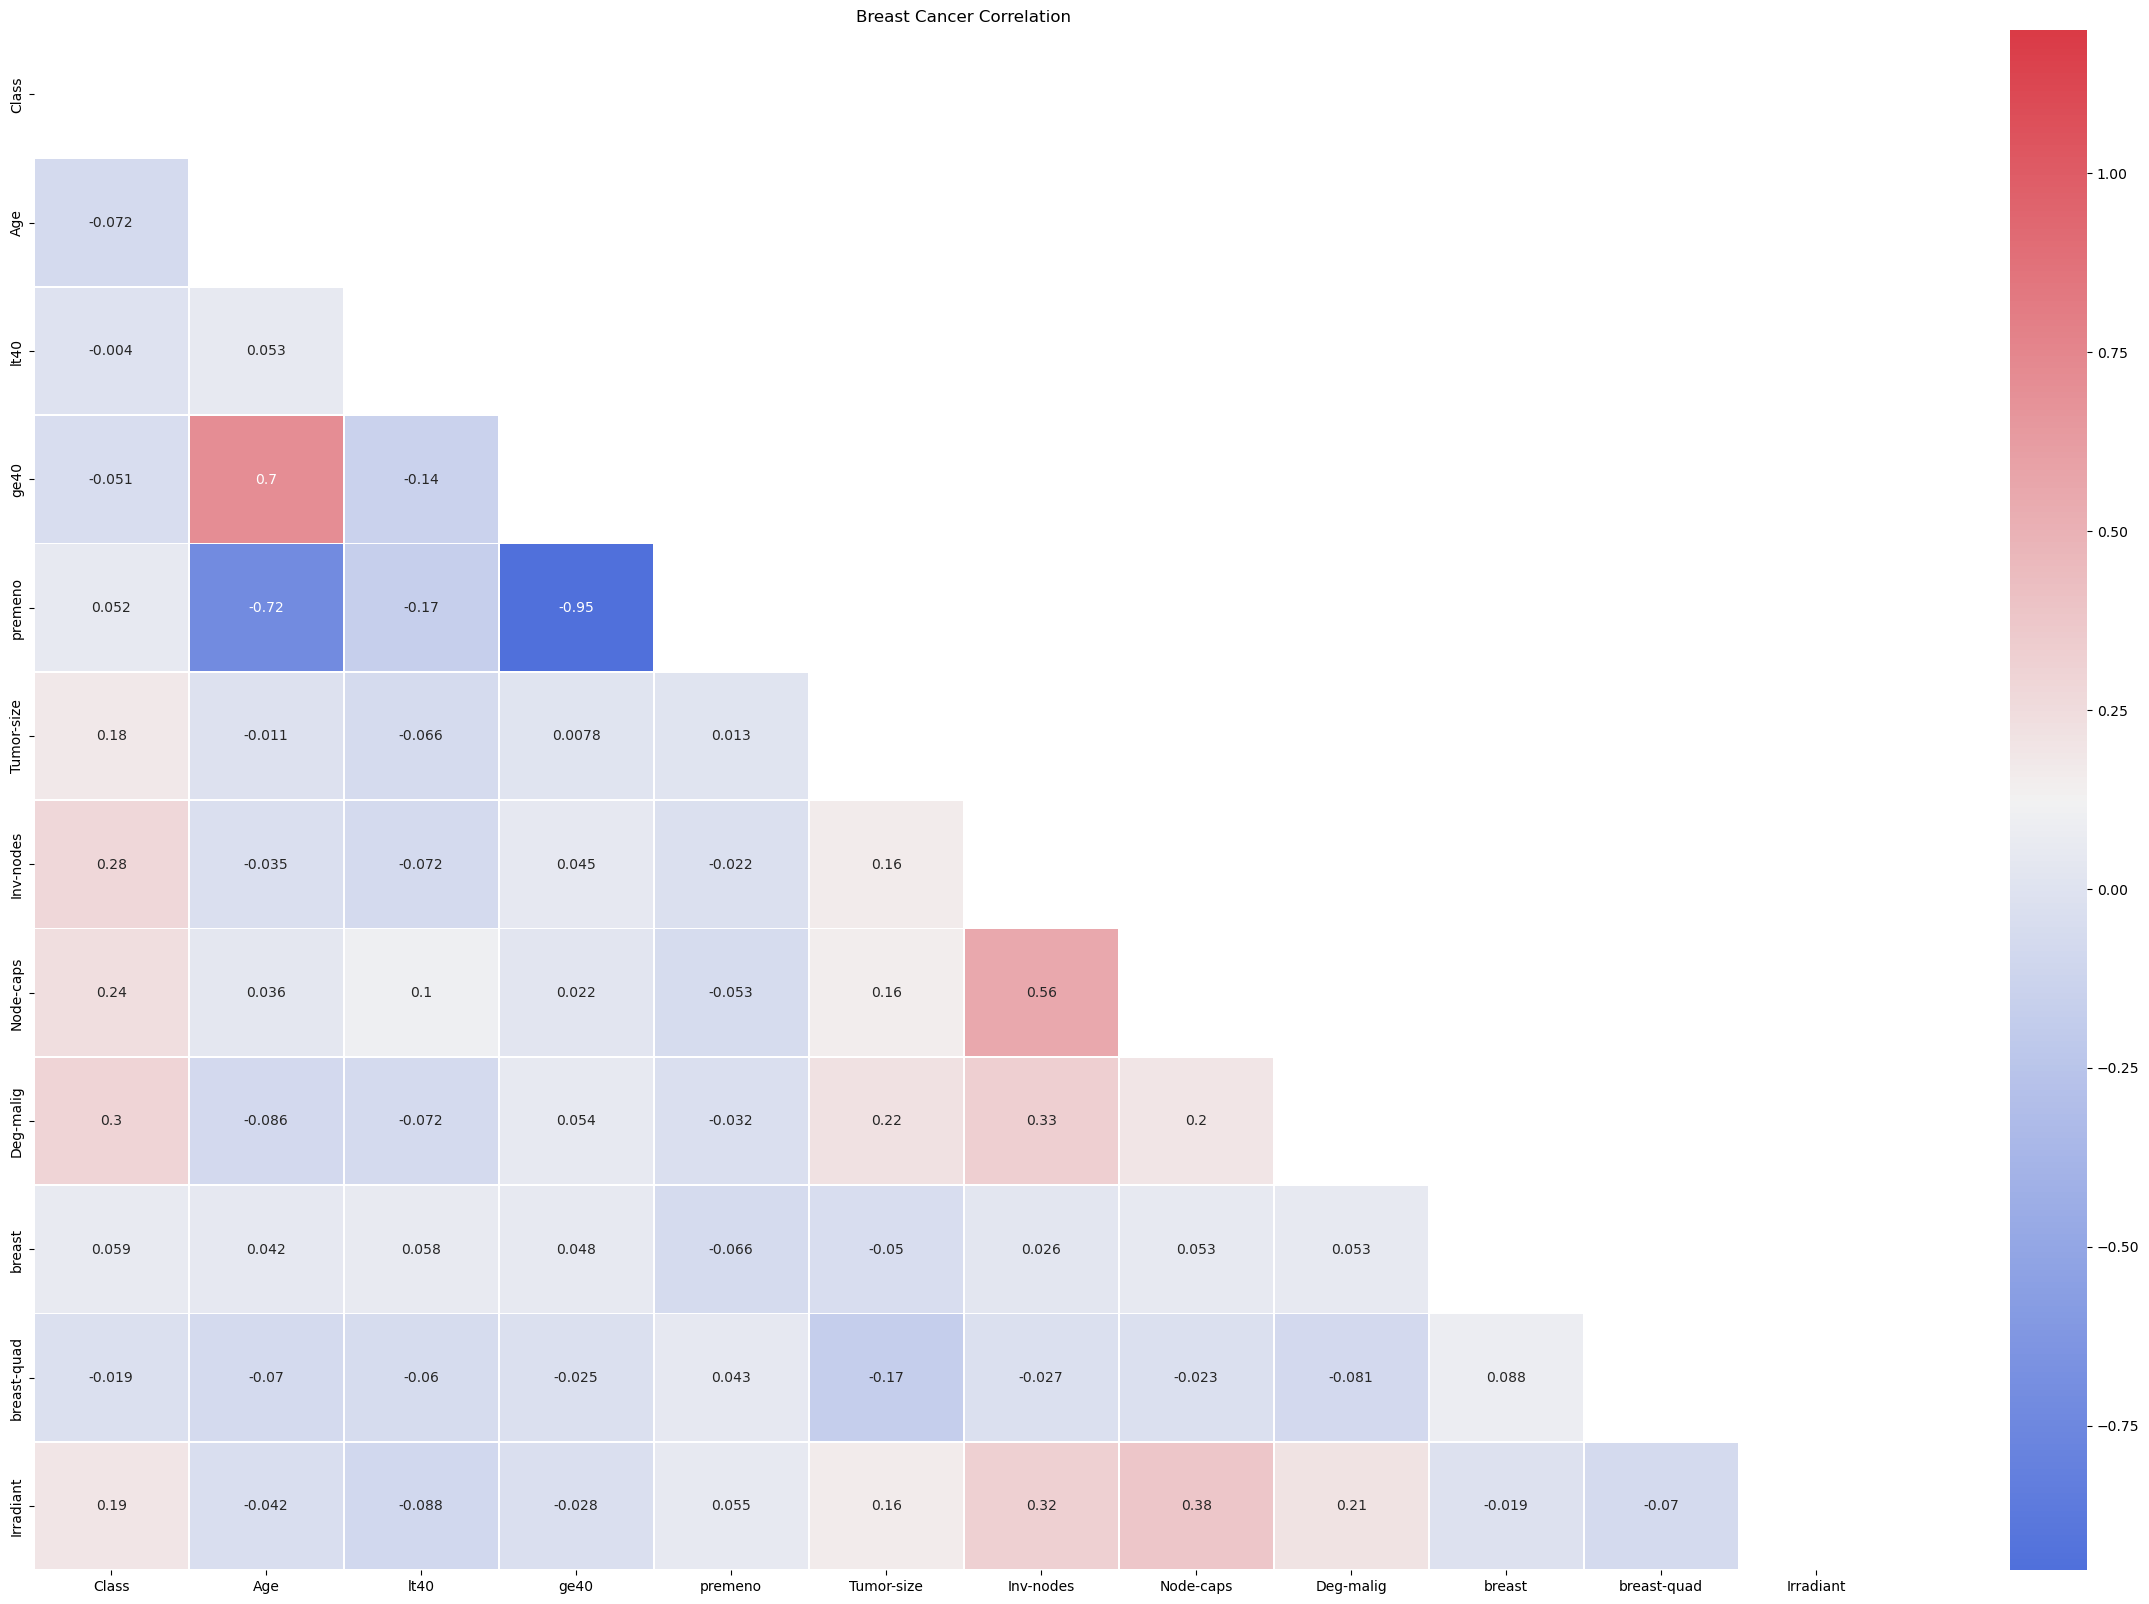

In [119]:
# Analyse the correlation between every two features and result
corrMatt = all_df.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(30, 20))
plt.title('Breast Cancer Correlation')
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=0.5);

After analysing the correlation between every two features. We decided to delete breast since it has low relationship with all other features and result. 


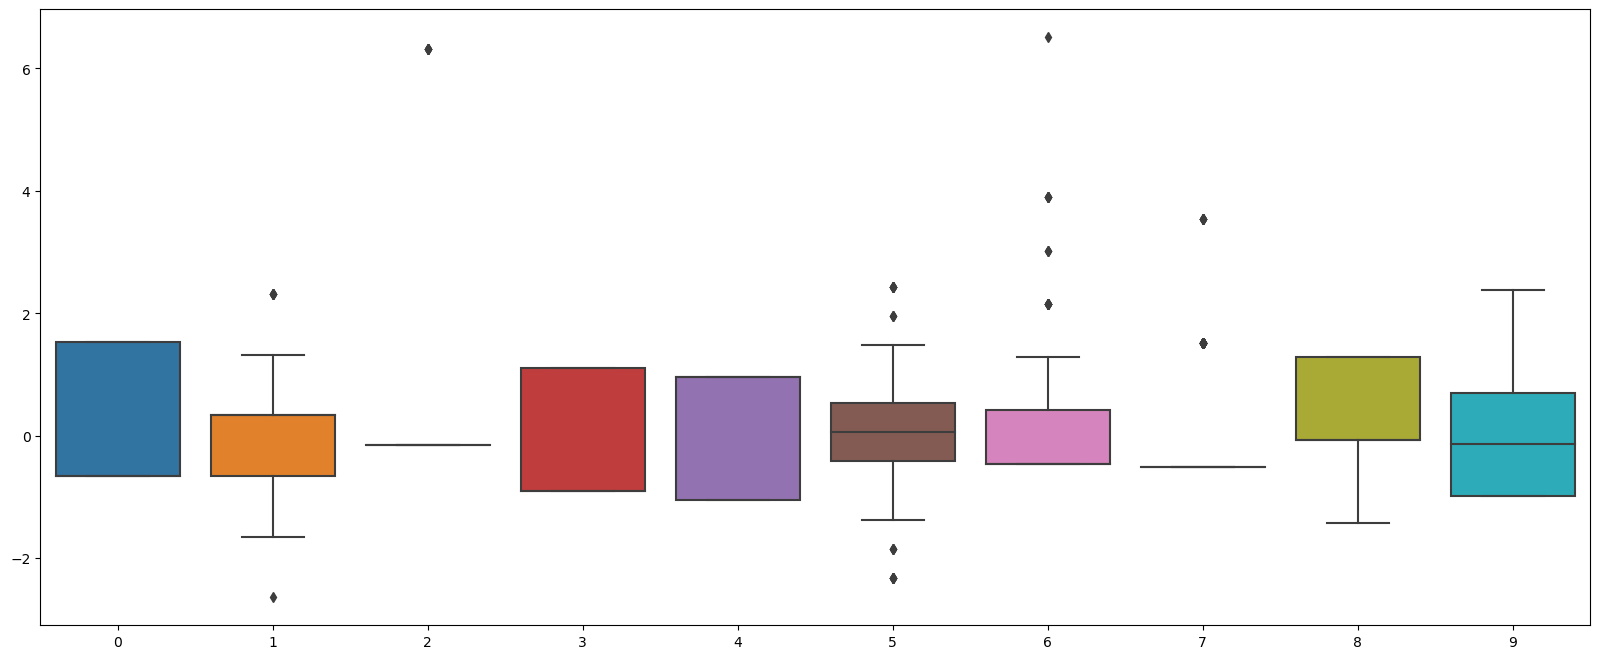

In [120]:
# Normalise the features to use zero mean normalisation
features = X.drop("breast", axis = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=features,ax=ax) 

After the normalisation. we can see that some features actually have weird distribution. For example, '2' in the above box chart, which is lt40 in the original dataset, has such distribution because about 98% of the original dataset is 0 and the rest is 1. Therefore, the normalisation has changed all the 1s into some value above 6 and this is the drawback of zero mean normalisation when data is very unequally distributed.

In [121]:
x_train, x_test, y_train, y_test = train_test_split(features, all_df['Irradiant'], test_size=0.3, random_state=1, stratify=all_df['Irradiant'])

### 2. Logistic Regression
Use logistic regression to draw the Plot confusion matrix. We found that misdiagnosis rate was __64.7%__ and the probability of not being diagnosed is __70%__

The 5-fold cross-validation accuracy score for this classifier is 0.79


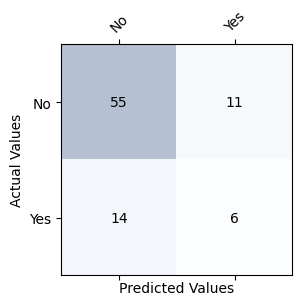

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

clf = LogisticRegression(max_iter = 1000)
cv_error = np.average(cross_val_score(clf, features, target, scoring='accuracy'))
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, cv_error))

# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
         ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
classes=["No","Yes"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');

### 3. SVM

In [123]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

svm = SVC(kernel="rbf", gamma='auto')

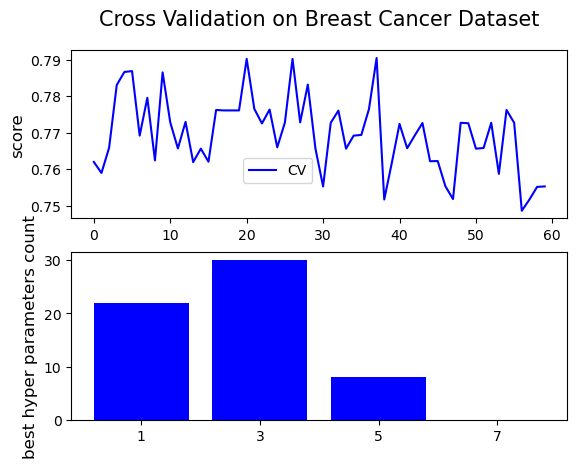

In [124]:
NUM_TRIALS = 60
X = features
y = target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 3, 5, 7]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv)
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)


best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int((i["C"]-1)/2)] = params.count(i)

# Plot scores on each trial for CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[1,3,5,7])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()

From the bar chart, we can conclude that __C = 1.0__ is the best hyperparameter.

In [139]:
svm = SVC(C=1.0, kernel="rbf", gamma='auto', degree=3)
cv_error_array = cross_val_score(svm, features, target, scoring='accuracy')
average = np.average(cv_error_array)
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation accuracy score for this classifier is 0.79


Use svc with __C = 1.0__ to draw the Plot confusion matrix. We found that misdiagnosis rate was __50%__ and the probability of not being diagnosed is __75%__

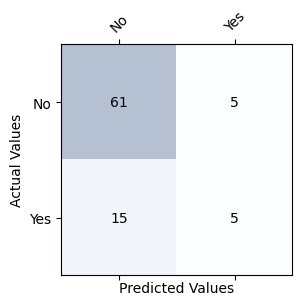

In [140]:
svm = SVC(C=1.0, kernel="rbf", gamma='auto', degree=3)
pred = svm.fit(x_train,y_train).predict(x_test)
cm = confusion_matrix(y_test, pred)
# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
         ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
classes=["No","Yes"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');

### 4. Decision Tree

In [141]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier()

In [142]:
NUM_TRIALS = 150
X = features
y = target

# Set up possible values of parameters to optimize over
p_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split':[5, 10, 15]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    clf = GridSearchCV(estimator=tree_clf, param_grid=p_grid, cv=cv)
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)

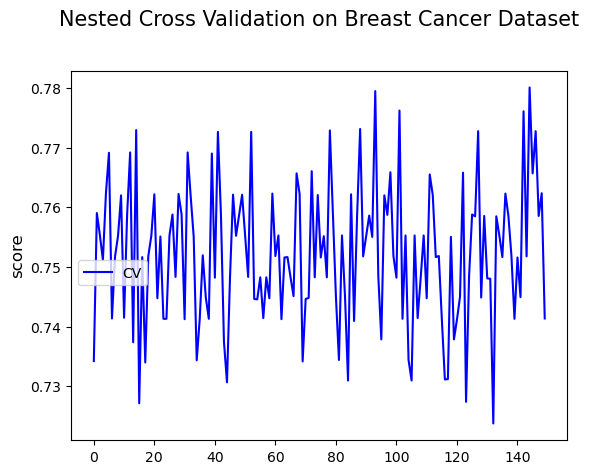

In [143]:
best_hyper_params_count = [[0 for i in range(5)] for j in range(3)]
for i in params:
    best_hyper_params_count[int(i['min_samples_split']/5-1)][int((i['max_depth']-3)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Nested Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.show()


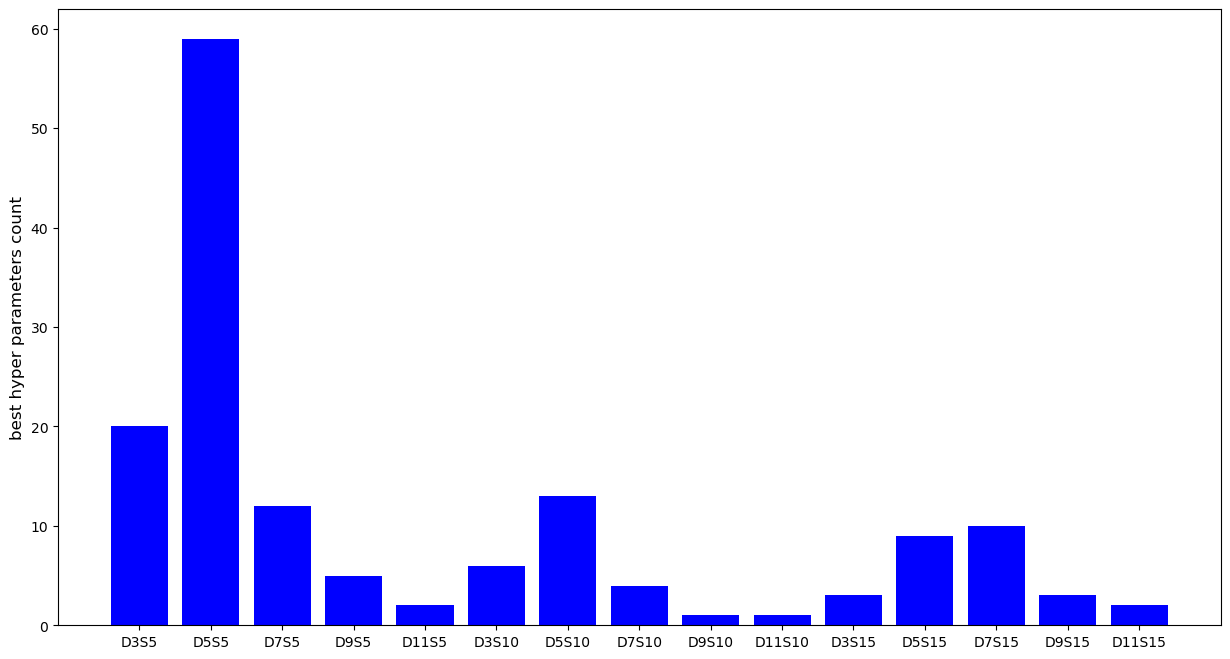

In [144]:
plt.figure(figsize = (15,8))

whole_list = best_hyper_params_count[0] + best_hyper_params_count[1] + best_hyper_params_count[2]

lang = []

for j in range(5,20,5):
    for i in range(3,13,2):
        lang.append('D' + str(i) + 'S' + str(j))       

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("best hyper parameters count", fontsize="12")

plt.show()

From the cross validation above, we can see that __max_depth = 5__ and __min_samples_split = 5__ give the best result.

In [145]:
tree_clf = tree.DecisionTreeClassifier(max_depth = 5, min_samples_split = 5)

cv_error = np.average(cross_val_score(tree_clf, features, target))

print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, cv_error))

The 5-fold cross-validation accuracy score for this classifier is 0.74


Use decision tree with __max_depth = 5__ and __min_samples_split = 5__ to draw the Plot confusion matrix. We found that misdiagnosis rate was __64.7%__ and the probability of not being diagnosed is __70%__

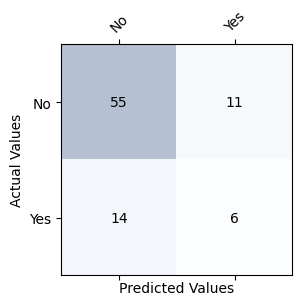

In [146]:
pred = tree_clf.fit(x_train,y_train).predict(x_test)
cm = confusion_matrix(y_test, pred)
# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
         ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
classes=["No","Yes"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');

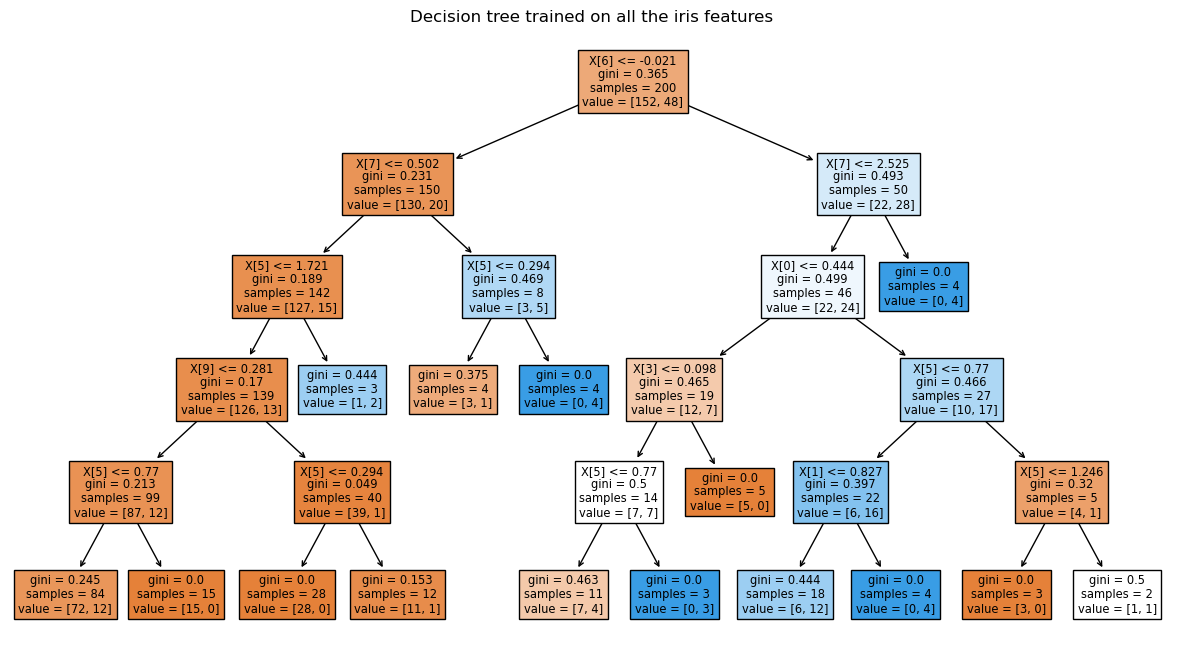

In [147]:
from sklearn.tree import plot_tree

plt.figure(figsize = (15,8))
plot_tree(tree_clf.fit(x_train,y_train), filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

### 5. ANN

In [159]:
# ! pip install -q -U keras-tuner
# from tensorflow.keras.models import Sequential
# import keras_tuner as kt
from tensorflow import keras

x_train, x_test, y_train, y_test = train_test_split(features, all_df['Irradiant'], test_size=0.3, random_state=1, stratify=all_df['Irradiant'])

# def model_builder(hp):
#     model = tf.keras.models.Sequential()

#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
#     model.add(keras.layers.Dense(input_dim=10, units=hp_units, activation='relu'))
#     model.add(keras.layers.Dense(1, activation='sigmoid'))

#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate),
#                 loss=tf.keras.losses.binary_crossentropy,
#                 metrics=['accuracy'])

#     return model

# tuner = kt.RandomSearch(model_builder,
#                      objective='val_accuracy',
#                      max_trials=5,  
#                      executions_per_trial=3,
#                      directory='my_dir')

# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# tuner.search(features, target, epochs=50, validation_split=0.2)

# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

model_one_layer=keras.models.Sequential()
model_one_layer.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
model_one_layer.add(keras.layers.Dense(1, activation='sigmoid'))
model_one_layer.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

model_two_layer=keras.models.Sequential()
model_two_layer.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
model_two_layer.add(keras.layers.Dense(16 ,activation="relu"))
model_two_layer.add(keras.layers.Dense(1, activation='sigmoid'))
model_two_layer.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [161]:
from sklearn.model_selection import KFold
import os

# root file for logging the learning process and can be visualised later in
# tensorboard
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
     import time
     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
     return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
kf = KFold(n_splits=5)
k=1

for train_index, test_index in kf.split(features):
    print("fold",k)
    # Split the data
    X_train, X_test = np.array(features)[train_index], np.array(features)[test_index]
    y_train, y_test = np.array(target)[train_index], np.array(target)[test_index]
    # tensorboard for visualising the training process later
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    # training and validation
    model_one_layer.fit(np.array(X_train), np.array(y_train), epochs=10, validation_data=(np.array(X_test), np.array(y_test)),callbacks=[tensorboard_cb])

    #save the model of each fold
    model_one_layer.save(os.path.join('fold_{}_model_one_layer.hdf5'.format(k)))
    
    model_two_layer.fit(np.array(X_train), np.array(y_train), epochs=10, validation_data=(np.array(X_test), np.array(y_test)),callbacks=[tensorboard_cb])

    #save the model of each fold
    model_two_layer.save(os.path.join('fold_{}_model_two_layer.hdf5'.format(k)))
    
    # evaluate the accuracy of each fold
    scores_one_layer = model_one_layer.evaluate(np.array(X_test), np.array(y_test), verbose=0)
    print("%s: %.2f%%" % (model_one_layer.metrics_names[1], scores_one_layer[1]*100))
    
    scores_two_layer = model_two_layer.evaluate(np.array(X_test), np.array(y_test), verbose=0)
    print("%s: %.2f%%" % (model_two_layer.metrics_names[1], scores_two_layer[1]*100))
    k=k+1


fold 1
Train on 228 samples, validate on 58 samples
Epoch 1/10
228/228 [==============================] - 0s 60us/sample - loss: 0.5612 - acc: 0.7763 - val_loss: 0.5736 - val_acc: 0.7586
Epoch 2/10
228/228 [==============================] - 0s 57us/sample - loss: 0.5558 - acc: 0.7807 - val_loss: 0.5691 - val_acc: 0.7586
Epoch 3/10
228/228 [==============================] - 0s 52us/sample - loss: 0.5513 - acc: 0.7851 - val_loss: 0.5653 - val_acc: 0.7586
Epoch 4/10
228/228 [==============================] - 0s 48us/sample - loss: 0.5475 - acc: 0.7851 - val_loss: 0.5609 - val_acc: 0.7586
Epoch 5/10
228/228 [==============================] - 0s 57us/sample - loss: 0.5443 - acc: 0.7807 - val_loss: 0.5553 - val_acc: 0.7586
Epoch 6/10
228/228 [==============================] - 0s 57us/sample - loss: 0.5397 - acc: 0.7807 - val_loss: 0.5509 - val_acc: 0.7586
Epoch 7/10
228/228 [==============================] - 0s 57us/sample - loss: 0.5358 - acc: 0.7807 - val_loss: 0.5467 - val_acc: 0.7586
Epo

229/229 [==============================] - 0s 44us/sample - loss: 0.5400 - acc: 0.7467 - val_loss: 0.4881 - val_acc: 0.8246
Epoch 10/10
229/229 [==============================] - 0s 44us/sample - loss: 0.5384 - acc: 0.7467 - val_loss: 0.4862 - val_acc: 0.8246
acc: 80.70%
acc: 82.46%
fold 4
Train on 229 samples, validate on 57 samples
Epoch 1/10
229/229 [==============================] - 0s 66us/sample - loss: 0.4833 - acc: 0.7642 - val_loss: 0.4959 - val_acc: 0.7895
Epoch 2/10
229/229 [==============================] - 0s 39us/sample - loss: 0.4813 - acc: 0.7642 - val_loss: 0.4956 - val_acc: 0.7895
Epoch 3/10
229/229 [==============================] - 0s 35us/sample - loss: 0.4796 - acc: 0.7686 - val_loss: 0.4950 - val_acc: 0.7895
Epoch 4/10
229/229 [==============================] - 0s 39us/sample - loss: 0.4778 - acc: 0.7598 - val_loss: 0.4946 - val_acc: 0.7895
Epoch 5/10
229/229 [==============================] - 0s 35us/sample - loss: 0.4762 - acc: 0.7598 - val_loss: 0.4945 - val_a

In [162]:
x_train, x_test, y_train, y_test = train_test_split(features, all_df['Irradiant'], test_size=0.3, random_state=1, stratify=all_df['Irradiant'])

model_one_layer.load_weights('fold_3_model_one_layer.hdf5')

y_pred=model_one_layer.predict(np.array(x_test))

loss, acc = model_one_layer.evaluate(np.array(x_test), np.array(y_test), verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


86/86 - 0s - loss: 0.5083 - acc: 0.7674
Restored model, accuracy: 76.74%


In [165]:
# ! pip install -q -U keras-tuner
# from tensorflow.keras.models import Sequential
# import keras_tuner as kt
from tensorflow import keras

x_train, x_test, y_train, y_test = train_test_split(features, all_df['Irradiant'], test_size=0.3, random_state=1, stratify=all_df['Irradiant'])

def model_builder(hp):
    model = Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
    model.add(keras.layers.Dense(input_dim=10, units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.binary_crossentropy,
                metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     max_trials=5,  
                     executions_per_trial=3,
                     directory='my_dir')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(features, target, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# model_one_layer=keras.models.Sequential()
# model_one_layer.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
# model_one_layer.add(keras.layers.Dense(1, activation='sigmoid'))
# model_one_layer.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

model_two_layer=keras.models.Sequential()
model_two_layer.add(keras.layers.Dense(32, input_dim=10,activation="relu"))
model_two_layer.add(keras.layers.Dense(16 ,activation="relu"))
model_two_layer.add(keras.layers.Dense(1, activation='sigmoid'))
model_two_layer.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

INFO:tensorflow:Reloading Oracle from existing project my_dir\untitled_project\oracle.json


TypeError: 'RandomSearch' object is not callable